In [1]:
###
# Setup
###
import os
from txt_utils import WORK_DIR
os.chdir(WORK_DIR)
import numpy as np
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')

# word2vec requires sentences as input
from txt_utils import get_sentences
sentences = []
for doc in df1['snippet']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

In [4]:
###
# Make document vectors from word embeddings
##


# Continuous bag-of-words representation
from gensim.models import Word2Vec
w2v = Word2Vec.load('w2v-vectors.pkl')

sentvecs = []
for sentence in sentences:
    vecs = [w2v.wv[w] for w in sentence if w in w2v.wv]
    if len(vecs)== 0:
        sentvecs.append(np.nan)
        continue
    sentvec = np.mean(vecs,axis=0)
    sentvecs.append(sentvec.reshape(1,-1))
sentvecs[0][0][:30]

array([-0.03755374,  0.0754557 , -0.01215807,  0.02724344, -0.05229275,
        0.04432235, -0.01363915, -0.0217172 , -0.06965669,  0.01931736,
        0.03053199,  0.01424754, -0.05688609, -0.01365547,  0.03937201,
        0.00451379, -0.06872099, -0.07032323, -0.02660567, -0.03353641,
       -0.00279393,  0.01400434, -0.00503904,  0.01532368, -0.0070127 ,
       -0.03338725, -0.02621535,  0.00085407, -0.095272  ,  0.06702889], dtype=float32)

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(sentvecs[0],
                  sentvecs[1])[0][0]

0.03170833

In [10]:
###
# Doc2Vec
###

from nltk import word_tokenize
docs = []

for i, row in df1.iterrows():
    docs += [word_tokenize(row['snippet'])]
shuffle(docs)

In [11]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
doc_iterator = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
d2v = Doc2Vec(doc_iterator,
                min_count=10, # minimum word count
                window=10,    # window size
                vector_size=200, # size of document vector
                sample=1e-4, 
                negative=5, 
                workers=4, # threads
                #dbow_words = 1 # uncomment to get word vectors too
                max_vocab_size=1000) # max vocab size

In [18]:
d2v.save('d2v-vectors.pkl')

In [19]:
# matrix of all document vectors:
D = d2v.docvecs.vectors_docs
D.shape

(32567, 200)

In [20]:
D

array([[ 0.00582994,  0.02074465,  0.01043716, ..., -0.01147972,
         0.00896086, -0.0171022 ],
       [-0.00141714,  0.00261384, -0.00126884, ..., -0.0043514 ,
         0.00323337, -0.0024522 ],
       [ 0.00107742,  0.00864137,  0.00520276, ..., -0.00417804,
        -0.00035239, -0.00319837],
       ..., 
       [ 0.00096156,  0.0066522 ,  0.00581312, ..., -0.00638843,
         0.00262438, -0.00334127],
       [-0.00407562,  0.0014511 , -0.00026437, ..., -0.00055323,
        -0.00038049, -0.00085787],
       [ 0.00091486,  0.00370449,  0.00027524, ..., -0.00367722,
         0.00792334, -0.00156432]], dtype=float32)

In [54]:
# infer vectors for new documents
d2v.infer_vector('the judge on the court')[:20]

array([ 0.01670747,  0.00713981,  0.00979282,  0.00011106, -0.00102037,
       -0.0291422 , -0.0145852 ,  0.0129413 ,  0.00944225, -0.01008553,
       -0.0263568 ,  0.01376887,  0.00145844, -0.00918259, -0.01461684,
       -0.00357082,  0.01180157,  0.00342607, -0.00278648,  0.01083328], dtype=float32)

In [21]:
# get all pair-wise document similarities
pairwise_sims = cosine_similarity(D)
pairwise_sims.shape

(32567, 32567)

In [22]:
pairwise_sims[:3,:3]

array([[ 1.00000012,  0.94964367,  0.97148967],
       [ 0.94964367,  0.99999988,  0.92184258],
       [ 0.97148967,  0.92184258,  1.        ]], dtype=float32)

In [23]:
# Document clusters
from sklearn.cluster import KMeans

# create 50 clusters of similar documents
num_clusters = 50
kmw = KMeans(n_clusters=num_clusters)
kmw.fit(D)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [31]:
# Documents from an example cluster
for i, doc in enumerate(docs):
    if kmw.labels_[i] == 25:
        print(' '.join(doc[:9]))
    if i == 1000:
        break

Congress in the Antiterrorism and Effective Death Penalty Act
enactment of the Anti-terrorism and Effective Death Penalty Act
Convictions The Antiterrorism and Effective Death Penalty Act of
# ; s order that the state could not
jurisdiction and remand cases in which the death penalty
instructions based on the death penalty law in a
not applying the Antiterrorism and Effective Death Penalty Act
less in favor of the death penalty . He
eighth and fourteenth amendments . Because the death penalty
approval from the DOJ to seek the death penalty
probably receive a lengthy prison sentence or the death
, has a & quot ; right & quot
because this is a capital case carrying the death
whether the defendant was eligible for the death penalty
Framework . The Federal Death Penalty Act Generally Under


In [32]:
# t-SNE for visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
d2v_tsne = tsne.fit_transform(D)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 32567 samples in 0.385s...
[t-SNE] Computed neighbors for 32567 samples in 239.985s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32567
[t-SNE] Computed conditional probabilities for sample 2000 / 32567
[t-SNE] Computed conditional probabilities for sample 3000 / 32567
[t-SNE] Computed conditional probabilities for sample 4000 / 32567
[t-SNE] Computed conditional probabilities for sample 5000 / 32567
[t-SNE] Computed conditional probabilities for sample 6000 / 32567
[t-SNE] Computed conditional probabilities for sample 7000 / 32567
[t-SNE] Computed conditional probabilities for sample 8000 / 32567
[t-SNE] Computed conditional probabilities for sample 9000 / 32567
[t-SNE] Computed conditional probabilities for sample 10000 / 32567
[t-SNE] Computed conditional probabilities for sample 11000 / 32567
[t-SNE] Computed conditional probabilities for sample 12000 / 32567
[t-SNE] Computed conditional probabilities for 

In [ ]:
vdf = pd.DataFrame(d2v_tsne,
                  columns=['x-tsne', 'y-tsne'])
vdf['cluster'] = kmw.labels_

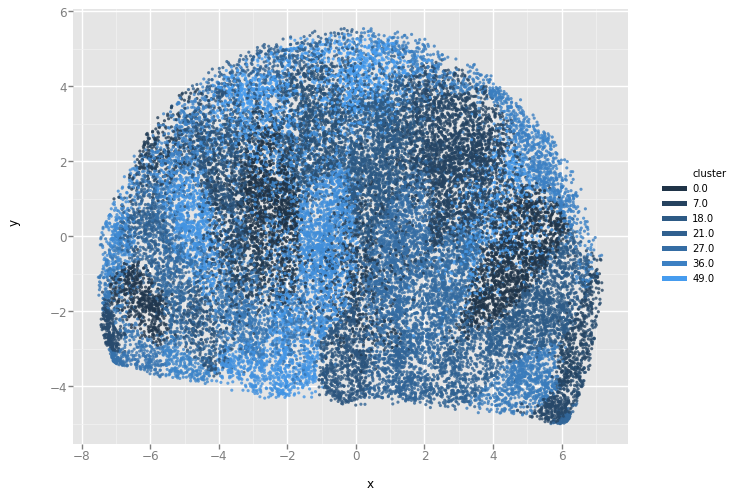

In [46]:
import ggplot as gg
vdf = pd.DataFrame(d2v_tsne,
                  columns=['x', 'y'])
vdf['cluster'] = kmw.labels_

chart = gg.ggplot( vdf, gg.aes(x='x', y='y', color='cluster') ) \
                  + gg.geom_point(size=10, alpha=.8, label='cluster') 
chart.show()